# MLTSA - Homework #1

In [2]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression 
from scipy.optimize import minimize

In [3]:
# Reading in data:
grbAG = pd.read_csv('https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv', sep=',')

In [4]:
# Checking dataframe + adding logtime col
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


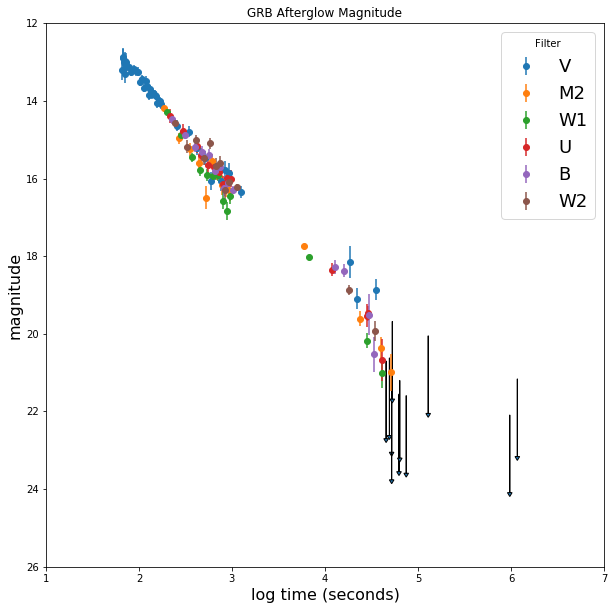

In [5]:
# Magnitude vs logtime scatter plot:

fig = plt.figure(figsize=(10,10))

#Plot points in each filter separately:
for f in grbAG['filter'].unique():
    plt.errorbar(grbAG['logtime'].where(grbAG['filter'] == f), 
                 grbAG['mag'].where(grbAG['filter'] == f), 
                 yerr = grbAG['magerr'], fmt = 'o', label=str(f))

#Plot arrows for upperlimit points:
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    plt.arrow(grbAG.loc[i].logtime, 
            grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
plt.ylim(26,12)
plt.xlim(1,7)
plt.legend(fontsize=18, title='Filter')

plt.xlabel('log time (seconds)', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.title('GRB Afterglow Magnitude')

Figure 1: Scatter plot of GRB afterglow magnitude vs. log time (in seconds) in six different filters with uncertainties. Observations beyond the upper limit of their respective filter are marked with an arrow. It's good practice to visualize the dataset you're trying to fit before blindly plugging the data into a fitting algorithm.  

## Fitting a line via the normal equation:

$$(a \:\: b)^T = (X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$$ 

In the above equation, X is an Nx2 matrix (N being the length of the dataset) where the first column is all ones and the second column is the values of the independent variable, y is the dataset of the dependent observations, and a & b are the intercept and slope, respectively, of the line that best fits the points.

In [6]:
# Create an Nx2 matrix X, where the first column is all ones and the second column is the values of the independent
# variable, in this case, (log)time:
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)), grbAG['logtime'][np.where(grbAG.upperlimit == 0)[0]]]

y = grbAG['mag'][np.where(grbAG.upperlimit == 0)[0]] #Only want x & y values below upperlimit

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)

shape of the input array X (108, 2)
shape of the input array y (108,)


In [7]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) #numpy can be used to do the linear alg operations
                                           
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fitting a line via sklearn linear regression:

In [8]:
lr = LinearRegression().fit(X,y)

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


sklearn.LinearRegression returns the same parameters as the ones obtained from the Normal Equation. 

According to the sklearn documentation:

>LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

Since the normal equation has an analytical solution, the sklearn algorithm is able to invert the matrices given to it so it is unsuprising that the result is the same as the analytical solution.

## Minimizing the L1 objective function:

In [11]:
def line(x, slope, intercept):
    '''
    Returns function of a straight line
    
    Inputs
    ======
    x: 1-D array of domain values
    intercept: value of y-intercept 
    slope: slope of the line 
    '''
    return (x*slope) + intercept

def l1(args, x, y):
    '''
    L1 objective function
    
    Inputs
    ======
    args: parameters of model
    x: 1-D array of the independent variable
    y: 1-D array of the dependent variable
    '''
    a, b = args
    
    return np.sum(np.abs(line(x, a, b) - y))

initialGuess = (10, 1) #Doesn't have to be a close guess for a simple model

x = grbAG['logtime'][np.where(grbAG.upperlimit == 0)[0]]

l1Solution = minimize(l1, initialGuess, args=(x, y))

print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.304339341180192
 hess_inv: array([[ 0.0075934 , -0.01591229],
       [-0.01591229,  0.0341321 ]])
      jac: array([-1.95810747,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 228
      nit: 11
     njev: 55
   status: 2
  success: False
        x: array([2.64023378, 8.22681524])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


Hmm so the minimization of L1 returns somewhat different parameter values than the previous methods. 

normal: slope = 2.51, intercept = 8.58
sklearn: slope = 2.51, intercept = 8.58
L1: slope = 2.64, intercept = 8.23
chi2: slope = 2.51, intercept = 8.58


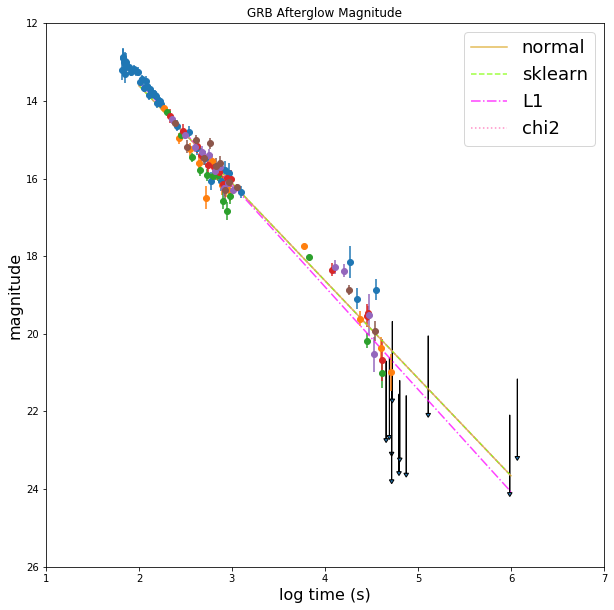

In [12]:
### Define line-plotting function:

def plotline(x, y, method, clr='k', linestyle='-', Label=None):
    
    '''
    This function plots a line using the parameters (slope & intercept)
    generated by a specified method.
    
    Inputs
    ======
    
    x: 1-D numpy array or pandas series of floats representing the independent variable
    y: 1-D numpy array or pandas series of floats representing the dependent variable
    method: technique used to specify line parameters.
        -normal: fits parameters 'manually' using the Normal Equation
        -sklearn: fits parameters using sklearn.linear_model.LinearRegression.fit()
        -L1: fits parameters by minimizing the L1 objective function
        -chi2: fits parameters by minimizing the chi-squared objective function
    clr, linestyle, Label: passed to style kwargs in matplotlib.pyplot.plot()
    '''
    
    if method == 'normal':
        
        X = np.c_[np.ones((len(x),1)), np.array(x)]
        
        b, a = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    if method == 'sklearn':
        
        X = np.c_[np.ones((len(x),1)), x]
        
        lr = LinearRegression().fit(X,y)
        
        b, a = lr.intercept_, lr.coef_[1]
    
    if method == 'L1':
        
        def line(x, slope, intercept):
            return (x*slope) + intercept

        def l1(args, x, y):
            a, b = args
            return np.sum(np.abs(line(x, a, b) - y))

        initialGuess = (10, 1) 

        l1Solution = minimize(l1, initialGuess, args=(x, y))
      
        a, b = l1Solution.x
        
    if method == 'chi2':
        
        def line(x, slope, intercept):
            return (x*slope) + intercept
        
        def chi2(args, x, y):
            m, b = args
            return np.sum(((line(x, m, b) - y)**2) / np.var(y))
        
        initialGuess = (10, 1) 

        chi2Solution = minimize(chi2, initialGuess, args=(x, y))

        a, b = chi2Solution.x
        
    print("{}: slope = {:.2f}, intercept = {:.2f}".format(method, a, b))
    
    x_ = np.arange(2,7) #set separate domain for lines so we can see them in the upperlimit regime
    
    plt.plot(x_, a * x_ + b, c = clr, ls=linestyle, label = Label, alpha=0.75)
    
###

# Scatter plot from earlier, then add fits:

ax = plt.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG['filter'].unique():
    plt.errorbar(grbAG['logtime'].where(grbAG['filter'] == f), 
                 grbAG['mag'].where(grbAG['filter'] == f), 
                 yerr = grbAG['magerr'], fmt = 'o', label=None)
    
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    plt.arrow(grbAG.loc[i].logtime, 
                grbAG.loc[i].magerr, 0, 2, 
                head_width=0.05, head_length=0.1, ec='k')
    
x = grbAG['logtime'][np.where(grbAG.upperlimit == 0)[0]]    
y = grbAG['mag'][np.where(grbAG.upperlimit == 0)[0]]    

#normal equation
plotline(x, y,'normal', 'goldenrod', '-', 'normal')
         
#sklearn
plotline(x, y,'sklearn', 'chartreuse', '--', 'sklearn')
         
#minimize L1
plotline(x, y, 'L1', 'magenta', '-.', 'L1')
         
#minimize chi2
plotline(x, y, 'chi2', 'hotpink', ':', 'chi2')

plt.ylim(26,12)
plt.xlim(1,7)
plt.legend(fontsize=18)

plt.xlabel('log time (s)', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.title('GRB Afterglow Magnitude')
plt.legend(fontsize=18)

Figure 2: Same as Figure 1 with best-fit lines from four different fitting methods added.

    -normal: fits parameters 'manually' using the Normal Equation
    -sklearn: fits parameters using sklearn.linear_model.LinearRegression.fit()
    -L1: fits parameters by minimizing the L1 objective function
    -chi2: fits parameters by minimizing the chi-squared objective function
    
The lines returned by the normal equation, sklearn.LinearRegression, and chi squared all have nearly identical parameters, whereas the line returned by the minimization of L1 has a slightly increased slope and a slightly decreased intercept.  

## Parameter results of each method:

| method | slope | intercept | 
|--------|-------|-----------|
|Normal  |8.58   |2.51       |
|sklearn |8.58   |2.51       |
|L1      |8.23   |2.64       |
|$\chi^2$|8.58   |2.51       |